# Importación de librerias

In [1]:
# 📚 Importación de librerías

# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


# Importación del dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
# Cargar los datos
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


# Análisis inicial de datos

#  Codificación de variable objetivo y limpieza

In [3]:
# Codificar variable MatchResult (Ganados = 1)
le = LabelEncoder()
data['MatchResult'] = le.fit_transform(data['MatchResult'])
if le.classes_[0] == 'Ganados':  # Asegura que 'Ganados' sea 1
    data['MatchResult'] = 1 - data['MatchResult']



# Selección y escalamiento de variables

In [4]:
features = [
    'RLethalGrenadesThrown',
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'RoundFlankKills',
    'Survived',
    'RoundStartingEquipmentValue',
    'TeamStartingEquipmentValue',
    'MatchKills',
    'MatchFlankKills',
    'MatchAssists',
    'MatchHeadshots',
    'outlier'
]

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])


# Agregación por equipo y partido

In [5]:
df_agg = data.groupby(['MatchId', 'InternalTeamId', 'MatchResult']).agg(
    Avg_RLethalGrenadesThrown=('RLethalGrenadesThrown', 'mean'),
    Sum_RoundKills=('RoundKills', 'sum'),
    Sum_RoundAssists=('RoundAssists', 'sum'),
    Avg_RoundHeadshots=('RoundHeadshots', 'mean'),
    Avg_RoundFlankKills=('RoundFlankKills', 'mean'),
    Avg_Survived=('Survived', 'mean'),
    Avg_RoundStartingEquipmentValue=('RoundStartingEquipmentValue', 'mean'),
    Avg_TeamStartingEquipmentValue=('TeamStartingEquipmentValue', 'mean'),
    Sum_MatchKills=('MatchKills', 'first'),
    Sum_MatchFlankKills=('MatchFlankKills', 'first'),
    Sum_MatchAssists=('MatchAssists', 'first'),
    Sum_MatchHeadshots=('MatchHeadshots', 'first'),
    Avg_outlier=('outlier', 'mean')
).reset_index()

X = df_agg.drop(columns=['MatchId', 'InternalTeamId', 'MatchResult'])
y = df_agg['MatchResult']


¿Qué es "Agregación por equipo y partido"?
Cuando trabajamos con datos de un juego por rondas como CS:GO, las métricas como kills, headshots, o daño, se registran por jugador y por ronda.

Pero la pregunta de negocio es:

¿El equipo completo ganó o perdió el partido completo?

Por eso se necesita agregar esos datos de bajo nivel (jugador/ronda) a un nivel resumen por equipo en el partido.

🔸 Ejemplo práctico:
Supongamos que el equipo Terrorist jugó 15 rondas en un partido. Por cada ronda tenemos:

Número de kills

Headshots

Equipamiento

¿Sobrevivió o no cada jugador?

Agregación significa aplicar funciones como:

sum() → total de kills del equipo en el partido

mean() → promedio de headshots por ronda

first() → tomar el valor que ya representa al equipo en todo el match

# División del conjunto de datos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# Entrenamiento del modelo Random Forest (500 árboles)

In [7]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42,
    verbose=1
)
model.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=42, verbose=1)

# Evaluación del modelo

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


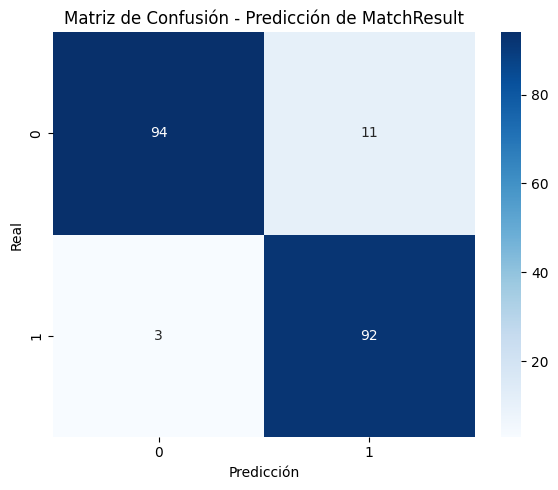

AUC ROC: 0.9730


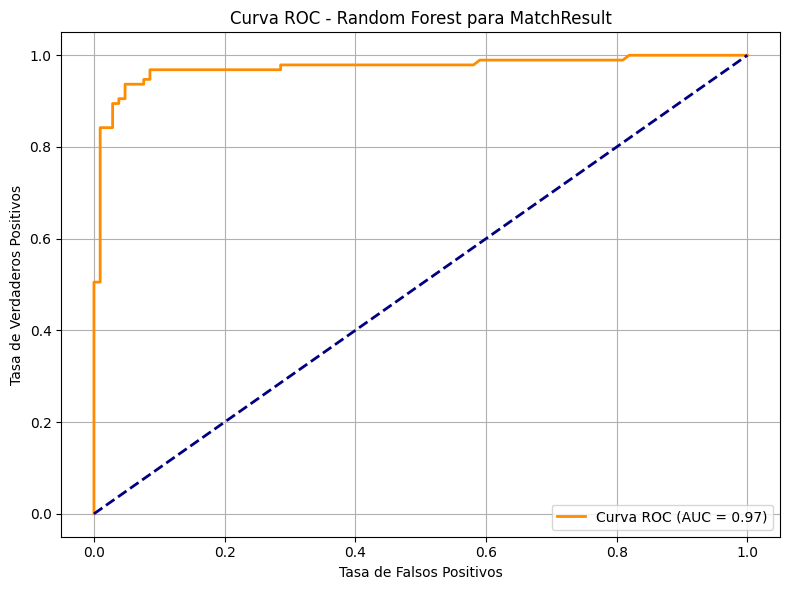

In [8]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Predicción de MatchResult")
plt.tight_layout()
plt.show()

roc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Random Forest para MatchResult")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Reporte de Clasificacion

In [9]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       105
           1       0.89      0.97      0.93        95

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



# Curva ROC

In [10]:
# Curva ROC
roc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc:.4f}")

AUC ROC: 0.9730


# Importancia de las caracteristicas

/tmp/ipython-input-11-2963107233.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


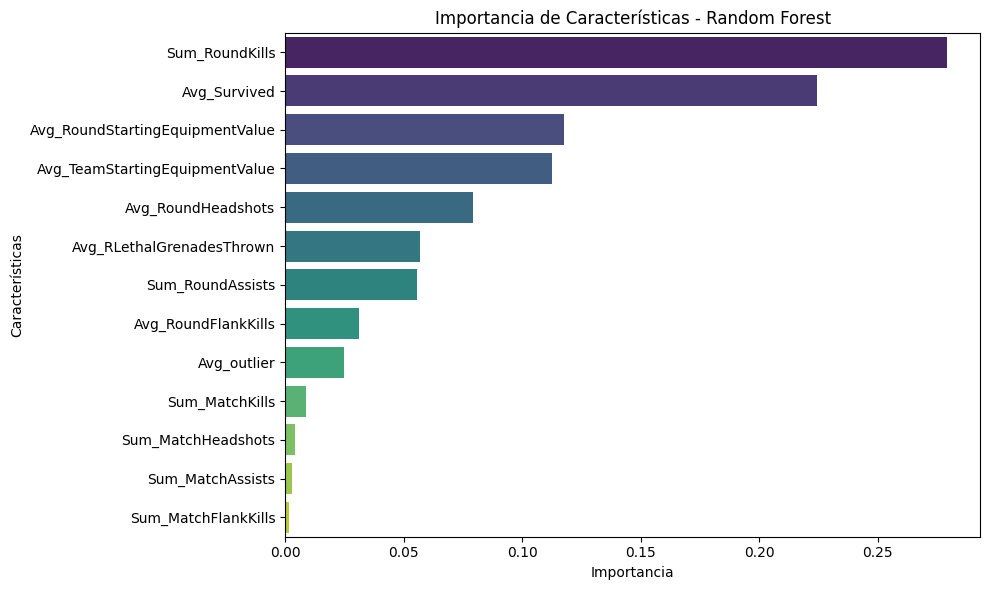


Importancia de características:
Sum_RoundKills                     0.279221
Avg_Survived                       0.224611
Avg_RoundStartingEquipmentValue    0.117730
Avg_TeamStartingEquipmentValue     0.112461
Avg_RoundHeadshots                 0.079426
Avg_RLethalGrenadesThrown          0.056849
Sum_RoundAssists                   0.055719
Avg_RoundFlankKills                0.031328
Avg_outlier                        0.024925
Sum_MatchKills                     0.008802
Sum_MatchHeadshots                 0.004328
Sum_MatchAssists                   0.002827
Sum_MatchFlankKills                0.001772
dtype: float64


In [11]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Importancia de Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()

print("\nImportancia de características:")
print(importances)


In [12]:
import pickle

with open('EquipoGanar.pkl', 'wb') as f:
    pickle.dump(model, f)


# Analisis

Precision 0.97 (clase 0): Cuando el modelo predice que un equipo perderá, acierta el 97% de las veces.

Recall 0.90 (clase 0): Detecta correctamente el 90% de los equipos que realmente perdieron.

Precision 0.89 (clase 1): Cuando predice que ganará, acierta el 89% de las veces.

Recall 0.97 (clase 1): Identifica correctamente al 97% de los equipos que realmente ganaron.

📌 F1-Score de 0.93 en ambas clases sugiere un equilibrio excelente entre precisión y recall.